In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jlinops

try:
    import cupy as cp
except:
    pass

# Set up toy problem

In [2]:
x = jlinops.shepplogan()

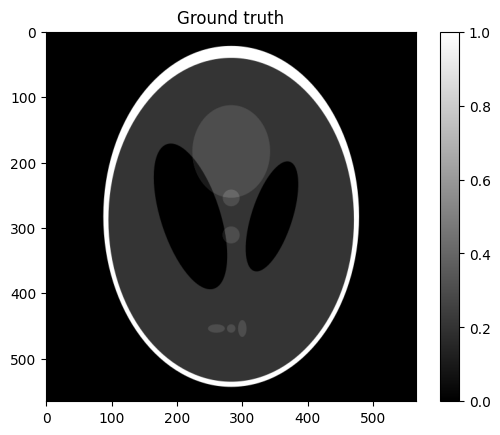

In [3]:
plt.imshow(x, cmap="gray")
plt.colorbar()
plt.title("Ground truth")
plt.show()

In [4]:
# Define measurement operator
F = jlinops.Gaussian2DBlurOperator(x.shape, blur_sigma=5.0, mode="reflect")

# Noise standard deviation and whitened measurement op
noise_stdev = 0.001
Ftilde = (1.0/noise_stdev)*F

# Noisy measurement
np.random.seed(0)
y = F.matvec_shaped(x) + noise_stdev*np.random.normal(size=x.shape)
ytilde = (1.0/noise_stdev)*y
ytilde_flat = ytilde.flatten()

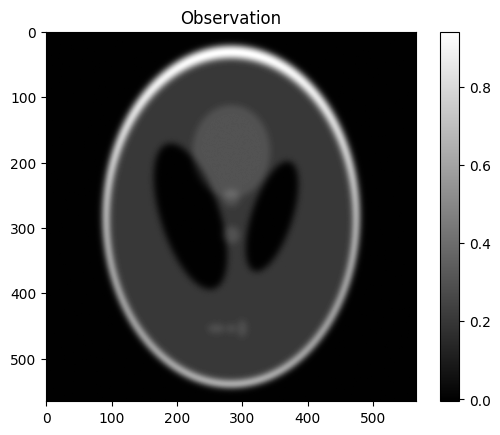

In [5]:
plt.imshow(y, cmap="gray")
plt.colorbar()
plt.title("Observation")
plt.show()

# TV-regularized least-squares reconstruction

In [6]:
# Set up solution operator and get reconstruction
lam = 1e2 # Regularization matrix
R = jlinops.Neumann2D(x.shape) # Anisotropic discrete gradient operator with Neumann BCs
Rtilde = np.sqrt(lam)*R

Q = (Ftilde.T @ Ftilde) + (Rtilde.T @ Rtilde)
Qinv = jlinops.CGInverseOperator(Q, which="scipy", tol=1e-3)
sol_op =  Qinv @ Ftilde.T

# Solve for solution
recon = sol_op @ ytilde_flat
recon = recon.reshape(x.shape)

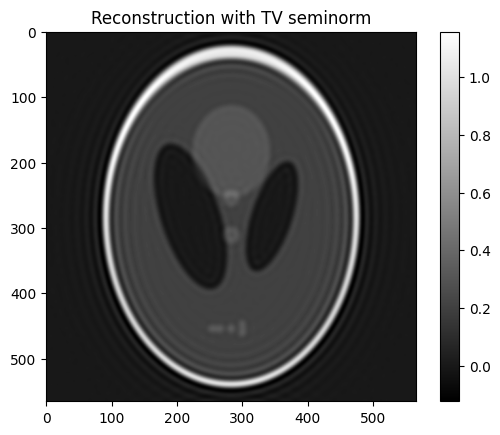

In [7]:
plt.imshow(recon, cmap="gray")
plt.colorbar()
plt.title("Reconstruction with TV seminorm")
plt.show()

##  With GPU

In [8]:
# Bring solution operator and obs onto GPU
sol_op_gpu = sol_op.to_gpu()
ytilde_flat_gpu = cp.asarray(ytilde_flat)

# Get reconstruction 
recon = sol_op_gpu @ ytilde_flat_gpu
recon = cp.asnumpy(recon)
recon = recon.reshape(x.shape)

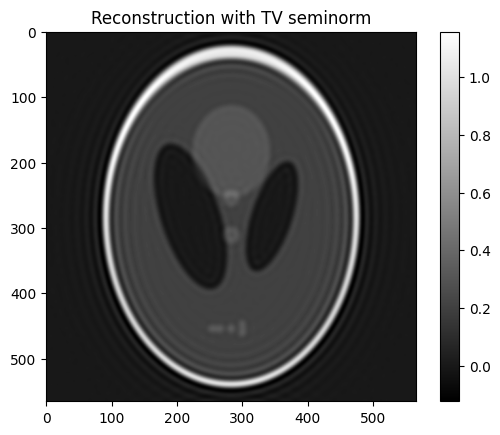

In [9]:
plt.imshow(recon, cmap="gray")
plt.colorbar()
plt.title("Reconstruction with TV seminorm")
plt.show()

# Same reconstruction, but obtained by converting problem to standard form

In [10]:
# Matrix spanning the nullspace
W = jlinops.MatrixLinearOperator( np.ones(x.shape).flatten() )

# Pseudoinverse of regularization operator
lam = 1e2
Rpinv = jlinops.Neumann2DPinvOperator(x.shape,eps=1e-10)

# Build oblique pseudoinverse
FtildeWpinv = jlinops.QRPinvOperator(Ftilde.dot(W.A)) 
oblique_pinv = jlinops.build_oblique_pinv(Ftilde, Rpinv, W, XWpinv=FtildeWpinv, check=False)

# Build solution operator for the standard-form transformation
A = Ftilde @ oblique_pinv
C = Ftilde @ oblique_pinv
Qtilde = (A.T @ A) + lam*jlinops.IdentityOperator( (A.shape[1],A.shape[1]) )
Qtildeinv = jlinops.CGInverseOperator(Qtilde, which="scipy", tol=1e-3)
sol_op = (oblique_pinv @ (Qtildeinv @ A.T)) + (W @ FtildeWpinv )  

In [18]:
jlinops.check_adjoint( (Ftilde.T @ A).to_gpu() )

True

In [ ]:
jlinops.check_adjoint( (oblique_pinv.T @ A).to_gpu() )

In [20]:
jlinops.check_adjoint( ( oblique_pinv.T @ ( Ftilde.T @ ( Ftilde @ oblique_pinv  )  ) ).to_gpu() )

False

In [22]:
jlinops.check_adjoint( ( ( oblique_pinv.T @  Ftilde.T) @ ( Ftilde @ oblique_pinv  )  ).to_gpu() )

False

In [24]:
jlinops.check_adjoint( ( ( oblique_pinv.T @  Ftilde.T @  Ftilde) @ oblique_pinv  ).to_gpu()  )

False

In [25]:
jlinops.check_adjoint( ( ( (oblique_pinv.T @  Ftilde.T) @  Ftilde) @ oblique_pinv  ).to_gpu()  )

False

In [26]:
jlinops.check_adjoint( ( ( oblique_pinv.T @  ( Ftilde.T @  Ftilde ) ) @ oblique_pinv  ).to_gpu()  )

False

In [15]:
jlinops.check_adjoint( (jlinops._AdjointLinearOperator(A) @ A).to_gpu() )

False

In [16]:
jlinops.check_adjoint( (jlinops._AdjointLinearOperator(Ftilde) @ Ftilde).to_gpu() )

True

In [17]:
jlinops.check_adjoint( (jlinops._AdjointLinearOperator(oblique_pinv) @ oblique_pinv).to_gpu() )

True

In [11]:
u = np.random.normal(size=A.shape[1])
v1 = A.matvec(u)
v2 = Ftilde @ ( oblique_pinv @ u)
np.linalg.norm(v1 - v2)

0.0

In [12]:
u = np.random.normal(size=A.shape[1])
v1 = A.T.matvec(u)
v2 = A.rmatvec(u)
v3 = oblique_pinv.T @ ( Ftilde.T @ u)
# print(np.linalg.norm(v1 - v3))
print(np.linalg.norm(v1 - v2))

0.0


In [ ]:
oblique_pinv.rmat

In [31]:
u = np.random.normal(size=oblique_pinv.shape[1])
v1 = oblique_pinv.T.matvec(u)
v2 = oblique_pinv.rmatvec(u)
print(np.linalg.norm(v1 - v2))

0.0


In [32]:
u = np.random.normal(size=Ftilde.shape[1])
v1 = Ftilde.T.matvec(u)
v2 = Ftilde.rmatvec(u)
print(np.linalg.norm(v1 - v2))

0.0


In [33]:
u = np.random.normal(size=F.shape[1])
v1 = F.T.matvec(u)
v2 = F.rmatvec(u)
print(np.linalg.norm(v1 - v2))

0.0


In [34]:
check_adjoint_prime(A.to_gpu())

(True, True)

In [31]:
check_adjoint_prime( (A.T @ A).to_gpu())

(False, False)

In [21]:
import copy

In [23]:
B = copy.deepcopy(A)

In [24]:
check_adjoint_prime( (A.T @ B).to_gpu())

(False, False)

In [28]:
check_adjoint_prime( (A.T @ C).to_gpu())

(False, False)

In [30]:
jlinops.check_adjoint(A.T.to_gpu())

True

In [36]:
check_adjoint_prime( A.T @ A )

(False, False)

In [150]:
A.matvec(np.random.normal(size=A.shape[1]))

array([ 71664.96120401,  71749.01096835,  71918.12015338, ...,
       -19843.67416301, -19883.63849713, -19904.49633492])

In [151]:
Ftilde @ ( oblique_pinv @ np.random.normal(size=A.shape[1]) )

array([-111435.93348691, -111415.95284281, -111377.41243102, ...,
        127712.23626728,  127701.75240413,  127696.80468545])

In [30]:
def check_adjoint_prime(op, n_rand_vecs=25, tol=1e-1):
    """
    Checks whether the proposed adjoint of a linear operator is really the adjoint.

    Returns:
        bool: whether the adjoint is correct to within the tolerance.
    """

    is_correct_adjoint_first = True
    is_correct_adjoint_second = True
    
    
    # First check matvecs and rmatvecs
    if op.device == "cpu":
        for j in range(n_rand_vecs):

            x = np.random.normal(size=op.shape[1]).flatten() # x
            y = np.random.normal(size=op.shape[0]).flatten() # y

            tilde_y = op.matvec(x) # \tilde{y} = A x
            tilde_x = op.rmatvec(y) # \tilde{x} = A y

            dot_x = np.dot(tilde_x, x) # dot product of x's
            dot_y = np.dot(y, tilde_y) # dot product of y's

            # Check: these two dot products should be the same
            if abs( dot_x - dot_y ) > tol:
                is_correct_adjoint_first = False
    
    else:
        for j in range(n_rand_vecs):

            x = cp.random.normal(size=op.shape[1]).flatten() # x
            y = cp.random.normal(size=op.shape[0]).flatten() # y

            tilde_y = op.matvec(x) # \tilde{y} = A x
            tilde_x = op.rmatvec(y) # \tilde{x} = A y

            dot_x = cp.dot(tilde_x, x) # dot product of x's
            dot_y = cp.dot(y, tilde_y) # dot product of y's

            # Check: these two dot products should be the same
            if abs( dot_x - dot_y ) > tol:
                is_correct_adjoint_first = False
                
                
                
    if op.device == "cpu":
        for j in range(n_rand_vecs):

            x = np.random.normal(size=op.shape[1]).flatten() # x
            y = np.random.normal(size=op.shape[0]).flatten() # y

            tilde_y = op @ x # \tilde{y} = A x
            tilde_x = op.T @ y # \tilde{x} = A y

            dot_x = np.dot(tilde_x, x) # dot product of x's
            dot_y = np.dot(y, tilde_y) # dot product of y's

            # Check: these two dot products should be the same
            if abs( dot_x - dot_y ) > tol:
                is_correct_adjoint_second = False
    
    else:
        for j in range(n_rand_vecs):

            x = cp.random.normal(size=op.shape[1]).flatten() # x
            y = cp.random.normal(size=op.shape[0]).flatten() # y

            tilde_y = op @ x # \tilde{y} = A x
            tilde_x = op.T @ y # \tilde{x} = A y

            dot_x = cp.dot(tilde_x, x) # dot product of x's
            dot_y = cp.dot(y, tilde_y) # dot product of y's

            # Check: these two dot products should be the same
            if abs( dot_x - dot_y ) > tol:
                is_correct_adjoint_second = False
    
    
    return is_correct_adjoint_first, is_correct_adjoint_second 

In [141]:
jlinops.check_adjoint(Rpinv.T.to_gpu())

True

In [146]:
jlinops.check_adjoint(Ftilde.T.to_gpu())

True

In [143]:
jlinops.check_adjoint(A.T.to_gpu())

True

In [149]:
jlinops.check_adjoint( ((A.T @ A).T).to_gpu() )

False

In [144]:
jlinops.check_adjoint( (A.T @ A).to_gpu() )

False

In [145]:
jlinops.check_adjoint( A.T.to_gpu() @ A.to_gpu() )

False

In [147]:
jlinops.check_adjoint(A.T @ A)

False

In [148]:
Ftilde.matmat(oblique_pinv)

ValueError: expected 2-d ndarray or matrix, not 0-d

In [121]:
jlinops.check_adjoint(Rpinv.to_gpu())

True

In [122]:
jlinops.check_adjoint(F.to_gpu())
jlinops.check_adjoint(Ftilde.to_gpu())

True

In [123]:
jlinops.check_adjoint(lam*jlinops.IdentityOperator( (A.shape[1],A.shape[1]) ))

True

In [33]:
Z = A.T @ A
Z = Z.to_gpu()
jlinops.check_adjoint(Z, tol=1e-1)

False

In [125]:
(A.T @ A).shape

(320356, 320356)

In [126]:
Z.shape

(320356, 320356)

In [128]:
Z.shape

(320356, 320356)

In [34]:
n_rand_vecs = 10
for j in range(n_rand_vecs):

    x1 = cp.random.normal(size=Z.shape[1]).flatten() # x
    y1 = cp.random.normal(size=Z.shape[0]).flatten() # y

    tilde_y1 = Z.matvec(x1) # \tilde{y} = A x
    tilde_x1 = Z.rmatvec(y1) # \tilde{x} = A y

    dot_x1 = cp.dot(tilde_x1, x1) # dot product of x's
    dot_y1 = cp.dot(y1, tilde_y1) # dot product of y's

    print(dot_x1 - dot_y1)
    
    # Check: these two dot products should be the same
#     if abs( dot_x - dot_y ) > tol:
#         is_correct_adjoint = False
                
#     return is_correct_adjoint

-0.625
0.25
2.25
0.25
0.09375
-1.5
-2.25
-0.25
2.125
-1.25


In [35]:
Z = Z.to_cpu()

In [36]:
n_rand_vecs = 10
for j in range(n_rand_vecs):

    x1 = np.random.normal(size=Z.shape[1]).flatten() # x
    y1 = np.random.normal(size=Z.shape[0]).flatten() # y

    tilde_y1 = Z.matvec(x1) # \tilde{y} = A x
    tilde_x1 = Z.rmatvec(y1) # \tilde{x} = A y

    dot_x1 = np.dot(tilde_x1, x1) # dot product of x's
    dot_y1 = np.dot(y1, tilde_y1) # dot product of y's

    print(dot_x1 - dot_y1)
    
    # Check: these two dot products should be the same
#     if abs( dot_x - dot_y ) > tol:
#         is_correct_adjoint = False
                
#     return is_correct_adjoint

2.0
-5.25
6.75
4.875
3.5
7.375
0.25
-6.5
-4.5
-11.0


In [95]:
Z = A
Z = Z.to_gpu()
jlinops.check_adjoint(Z, tol=1e-5)

True

In [96]:
Z = oblique_pinv.to_gpu()
jlinops.check_adjoint(Z, tol=1e-5)

True

In [75]:
jlinops.check_adjoint(Qtilde.to_gpu())

False

In [62]:
# Solve for solution
sol_op_gpu = sol_op.to_gpu()
standard_recon = sol_op_gpu @ cp.asarray(ytilde_flat)
standard_recon = cp.asnumpy(standard_recon)
standard_recon = standard_recon.reshape(x.shape)

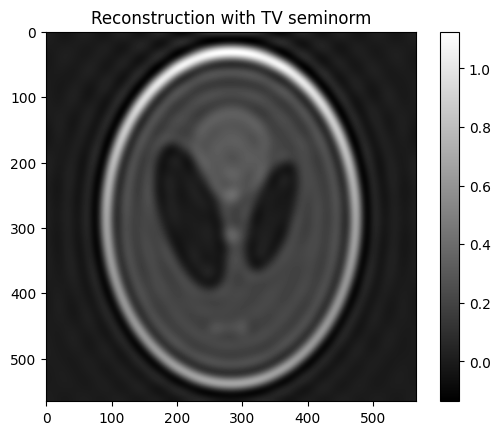

In [63]:
plt.imshow(standard_recon, cmap="gray")
plt.colorbar()
plt.title("Reconstruction with TV seminorm")
plt.show()

In [ ]:
plt

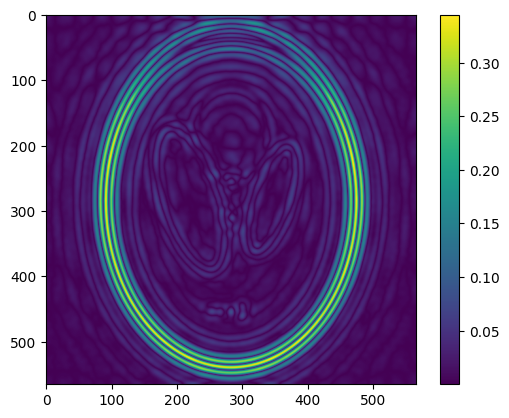

In [64]:
plt.imshow( np.abs(recon - standard_recon) )
plt.colorbar()
plt.show()